# The Event-Related Potential *for the practicing neuroscientist*

<div class="alert alert-block alert-info">
*Synopsis* <br><br>

**Data:** 1 s of scalp EEG data sampled at 500 Hz during 1,000 trials in two conditions.<br>

**Goal:** Characterize the response of the EEG in the two conditions.<br>

**Tools:** Visualization, event-related potential, confidence intervals, bootstrapping.

</div>

* [Introduction](#background)
    * [Background](#background)
    * [Case Study Data](#case-study-data)
    * [Goal](#goal)
    * [Tools](#tools)
    ---
* [Data Analysis](#data-analysis)
    * [Visual Inspection](#visual-inspection)
    * [Plotting the ERP](#plotting-the-erp)
    * [Confidence Intervals for the ERP (Method 1)](#cis-m1)
    * [Comparing ERPs](#comparing-erps)
    * [Confidence Intervals for the ERP (Method 2)](#cis-m2)
    * [A Bootstrap Test to Compare ERPs](#bootstrap)
    
    

## Background <a class="anchor" id="background"></a>

In [1]:
# BACKGROUND VIDEO

Voltage recordings from the scalp surface - the electroencephalogram or EEG - provide a powerful window into brain voltage activity.  Some of the earliest human EEG recording occurred in 1924, when Dr. Hans Berger made a remarkable discovery:  the EEG of a human subject at rest with eyes closed exhibits rhythmic activity, an approximately 10 Hz oscillation he labeled the alpha rhythm.  Although now studied for nearly 100 years, the definitive functional role (if any) of the alpha rhythm remains unknown.  Since then, many other EEG rhythms have been detected and labelled (typically with Greek letters) and the analysis of EEG rhythms remains an active area of research. 

Compared to other modalities for measuring brain activity, the EEG possesses both advantages and disadvantages.  Perhaps the most important advantages are:

1. The EEG is non-invasive, and
2. The EEG permits a high temporal resolution (on the order of milliseconds).
But, the EEG measure also suffers from significant disadvantages, the most devastating being the poor spatial resolution;  a single scalp electrode detects the summed activity from approximately 10 cm<sup>2</sup> of cortex.

In this chapter, we consider EEG data recorded from a single scalp electrode.  We will analyze these data to determine what (if any) activity is evoked following two different types of stimuli presented to a human subject.  In doing so, we will continue to develop our skills in MATLAB, and begin to see how this powerful tool can help us understand these time series data.  We begin with a brief description of the EEG data.

## Case Study: an EEG ERP task <a class="anchor" id="case-study-data"><a/>
An undergraduate student volunteers to participate in a psychology study at his university. In this study, EEG electrodes (sampling rate 500 Hz, i.e., 500 samples per second) are placed on the student's scalp, and he is seated in a comfortable chair in a dark, electrically isolated room.  The student is instructed to place headphones over his ears and listen to a series of repeated sounds.  The sounds consist of two tones - either a high pitch tone or a low pitch tone.  A single tone is presented once every few seconds, and the student responds with a button press to the low pitch tone.  The tone presentation is repeated to collect the EEG response to numerous presentations of the two tones, as illustrated here:

<img src="imgs/example_recording.png"></img>

In this cartoon illustration of the EEG experiment, the EEG electrodes are placed on the scalp surface of a human subject (left).  The EEG activity (blue) is recorded as a function of time during presentation of high pitch tones (black) and low pitch tones (orange).

Our collaborator leading this research study has agreed to provide us with EEG data recorded at a single electrode for 1000 presentations of the high pitch tone, and 1000 presentations of the low pitch tone.  In each presentation - or "trial" - she provides us with 1 s of EEG data, such that the tone occurs at 0.25 s into the trial.  She asks us to analyze these data to determine whether the EEG signal differs following the two tone presentations.

In [2]:
# Case study video

## Loading the Data

Our first step is to load the data into Python.  To do so, we use the function `loadmat()` from the `scipy.io` module as follows,

In [3]:
import scipy.io as sio
data = sio.loadmat('EEG-1.mat')

To understand the outcome of issuing this command, let's examine the variable `data` now present in the workspace.  This variable is a *dictionary* variable (execute `type(data)` and the result should be `dict`). To see the *keys* of a dictionary, use the `keys()` method.

In [4]:
data.keys()

['__globals__', 'EEGb', 'EEGa', '__header__', 't', '__version__']

The keys that start and end with two underscores ( `__` ) are private and contain information about the MATLAB file. The variables that we are interested in here are `EEGa`, `EEGb`, and `t`. These correspond to the EEG data recorded in the two conditions (i.e., EEGa to condition A and EEGb to condition B) as well as a time axis (t). Let's extract these variables from the `data` dictionary.

In [5]:
EEGa = data['EEGa']
EEGb = data['EEGb']
t = data['t']

<div class="alert alert-block alert-warning">
In general, a single underscore at the beginning of a variable, function or method indicates that this object should be treated as *private*. Double underscores often indicate that Python will interpret this object with some special instructions. In both cases, for what we are doing, we can usually ignore an object that starts with an underscore.
</div>

Let's use the `whos` command to get some more information about the variables.

In [6]:
whos

Variable   Type       Data/Info
-------------------------------
EEGa       ndarray    1000x500: 500000 elems, type `float64`, 4000000 bytes (3 Mb)
EEGb       ndarray    1000x500: 500000 elems, type `float64`, 4000000 bytes (3 Mb)
data       dict       n=6
sio        module     <module 'scipy.io' from '<...>s/scipy/io/__init__.pyc'>
t          ndarray    1x500: 500 elems, type `float64`, 4000 bytes


<div class="alert alert-block alert-warning">
We could also have used `EEGa.shape` to find out the dimensions of the variable `EEGa`.
</div>

In the *Data/Info* column we see *1000x500* for `EEGa` and `EEGb`.  Both variables are matrices with 1000 rows and 500 columns.  Our collaborator tells us that each row corresponds to a separate trial, and each column to a point in time.  So there are 1000 total trials, each consisting of 500 time points.  As a matter of convenience, we define a new variable to record the number of trials,

In [7]:
ntrials = EEGa.shape[0]

The `shape` property of an array is a *tuple* that indicates the size of each dimension. Adding `[0]` at the end tells Python to give us only the first value in the tuple. Recall that Python indexing starts at 0. This variable will be useful later, as we'll see. In fact, we can assign two variables at the same time if we want.

In [8]:
ntrials, nsamples = EEGa.shape

<div class="alert alert-block alert-info">

**Q.** Determine the size of the variable `EEGb`. How many rows and columns does it possess? Which dimension corresponds to trials and which corresponds to time?

</div>

<div class="alert alert-block alert-warning">
A *tuple* is another data structure in Python that is similar to an array or a list because it usually contains more than one element. Python treats each of these structures slightly differently, however. One of the most challenging things about starting with Python is learning to understand the different data structures. Here, we will mainly work with arrays, which are good for holding multidimensional data. If you are curious and want to know more about data structures, there is a very concise description <a href="http://thomas-cokelaer.info/tutorials/python/data_structures.html">here</a> to get you started.
</div>

### Visual Inspection
Both `EEGb` and `EEGa` are complicated variables that contain many elements. To understand these data, we might attempt to read the values contained in each element. For example, we can print out the EEG data for the first trial of condition A

In [9]:
print( EEGa[0, :] )

[ -1.85909632e-01   4.49876010e-01   1.06070801e+00  -4.71265246e-01
   1.68669327e+00   9.38221338e-01   2.21207038e-01   4.05491276e-01
   8.78879665e-01   5.23697825e-01  -2.35240678e+00  -9.24345879e-01
   7.66671797e-01  -4.64254999e-01   6.25953180e-02   1.51917029e+00
  -7.76400815e-01   8.14988739e-01  -1.58137285e-01  -6.17402518e-01
   2.07506393e-01   3.59430871e-01  -1.21455008e+00  -6.16715452e-01
  -4.81362032e-02   3.17982689e-01  -2.77459585e-01   4.14839815e-02
  -1.52257779e+00   1.31993666e+00   1.46836023e+00   1.84666100e+00
   5.23163980e-02   2.05515379e-01   2.27994679e-01  -1.34063464e+00
   5.61451651e-01   1.20391968e+00   1.06398658e+00   4.38748238e-01
   1.64443736e+00  -1.54713823e+00   6.41177787e-01  -1.13319311e+00
   1.06869889e+00   3.88678297e-01  -1.86251056e+00  -1.14074604e+00
  -4.59323117e-01   7.46220184e-01   4.40752835e-01  -7.05129357e-01
  -1.85879610e-01  -4.52021194e-02  -7.74389189e-01   1.55051475e+00
   1.12600755e+00  -1.14703552e+00

In this command, we index the first row of the matrix `EEGa` and print out all columns (corresponding to all moments of time).

<div class="alert alert-block alert-info">

**Q.** Upon issuing this command what do you find? Does the printout help you understand these data?<br><br>

**A.** You should observe a list of 500 numbers that begins <br><br>

    `-1.85909632e-01   4.49876010e-01   1.06070801e+00  -4.71265246e-01   1.68669327e+00   9.38221338e-01 ...`<br><br>
    
We might conclude that these numbers exhibit variability (i.e., the values are both positive and negative), but examining the data in this way is not particularly useful. For example, determining trends in th ebehavior (such as intervals of repeated activity) through inspection of these printed numbers alone is extremely difficult.

</div>

Printing out the data to the screen is not useful in this case. How else can we deepen our understanding of these data? Let’s make a plot. Fortunately, plotting the data is easily done in Python:

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

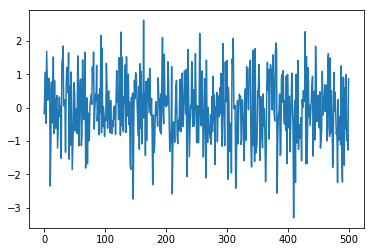

In [11]:
plt.plot(EEGa[0, :]) # Plot the data from condition A, trial 1.
plt.show()

Visualizing the data in this way, we immediately notice many features. First, let’s consider the axes. The horizontal axis extends from 1 to 500. This corresponds to the 500 columns in the variable EEGa. It would be more informative to plot the EEG data as a function of time rather than indices. Fortunately, we possess a variable `t` in the workspace that corresponds to the time axis. Determining the size of the variable `t`, we find it is a vector with 1 row and 500 columns. Each column corresponds to a point in time. 

<div class="alert alert-block alert-info">
**Q.** Plot the variable `t`. What is its range? 
</div>

This corresponds to the 1 s of EEG data recorded in each trial. We can also use the variable t to determine the sampling interval,

In [12]:
dt = t[0, 1] - t[0, 0]  # Determine the sampling interval

The new variable `dt` corresponds to the time between samples.

<div class="alert alert-block alert-info">
<p>
**Q.** What is the value of `dt`? We were told by our collaborator that the sampling frequency is 500 Hz. Is the value of `dt` consistent with this sampling frequency?
</p>
<br>
<p>
**A.** Yes, it is consistent. We find that dt is 0.002 s, or 2 ms. The sampling frequency of 500 Hz corresponds to one sample of the EEG data every 1/(500 Hz) = 2 ms. If the two were not consistent, we would return to our collaborator and figure out what has gone wrong. In general, it’s useful to ask such questions along the way to make sure we understand the formatting of the data and catch any potentially serious misunderstandings early in the analysis.
</p>
</div>

<div id="singleTrial">
We can now combine the time axis with the EEG data to make a more complete plot. Let’s also label the axes and give the plot a title.
</div>

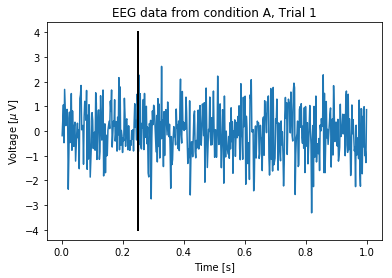

In [80]:
plt.plot(t[0], EEGa[0, :])    # Plot condition A, trial 1 data vs t.
plt.xlabel('Time [s]')         # Label the x-axis as time.
plt.ylabel('Voltage [$\mu$ V]')  # Label the y-axis as voltage.
plt.title('EEG data from condition A, Trial 1')  # Add a title

# Add a vertical line to indicate the stimulus time
plt.plot([0.25, 0.25], [-4,4], 'k', lw=2)

plt.show()

This plot provides a nice summary of the data in the first trial of condition A. A visual inspection of the plot suggests that these data exhibit complicated activity. We know from our collaborator that the stimulus occurs at time 0.25 s in each trial. Note how we indicated this time as a vertical line in the plot above. This command includes additional options that make the line black (`'k'`) and a bit wider (`lw=2`). 

<div class="alert alert-block alert-info">
**Q.** What else, if anything, can you say about the single trial of EEG data plotted above? Does the visual inspection reveal any particular change in the EEG activity following the stimulus presentation?
</div>

So far we have visualized only the data from condition A. Because we are interested in whether the EEG behaves differently in the two conditions, visualizing both conditions simultaneously would be of use. We can do this as follows:

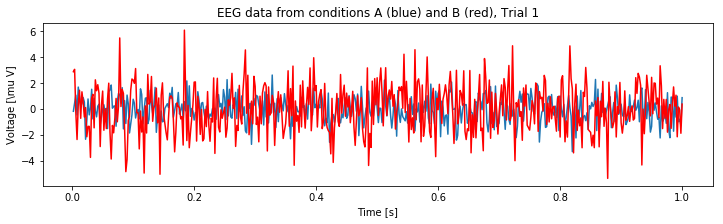

In [15]:
plt.figure(figsize=(12, 3)) # Resize the figure to make it easier to see
plt.plot(t[0],EEGa[0,:])    # Plot condition A, trial 1, data vs t,
plt.plot(t[0],EEGb[1,:], 'r')   # ... data from condition B, trial 1,
plt.xlabel('Time [s]')          # Label the x-axis as time.
plt.ylabel('Voltage [\mu V]')   # Label the y-axis as voltage.
plt.title('EEG data from conditions A (blue) and B (red), Trial 1')
plt.show()

<div class="alert alert-block alert-info">
**Q.** Compare the voltage traces from the first trial of conditions A and B as plotted above. What similarities and differences do you observe?
</div>

<div class="alert alert-block alert-info">
**Q.** The analysis has so far focused only on the first trial. Repeat this visual inspection of the data for different trials. What do you find? What similarities and differences exist between the two conditions across trials?
</div>

These techniques allow us to visualize the data one trial at a time. That is useful but can be time consuming, especially for a large number of trials. For the EEG data of interest here, each condition contains 1,000 trials, and to visualize each trial separately could require 2,000 plots. We can certainly create 2,000 plots, but the subsequent visual inspection would be time consuming and difficult. Fortunately, a more efficient visualization approach exists: we can display the entire structure of the data across both time and trials as an image:

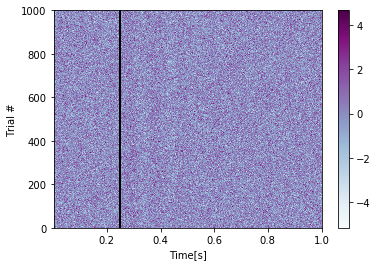

In [79]:
plt.imshow(EEGa, # Image the data from condition A.
           cmap='BuPu', # ... set the colormap (optional)
           extent=[t[0][0], t[0][-1], 1, ntrials], # ... set axis extents
           aspect='auto', # ... set aspect ratio 
           origin='lower') # ... move the origin to the lower left corner
plt.xlabel('Time[s]') # Label the axes
plt.ylabel('Trial #')
plt.colorbar() # Show voltage to color mapping
plt.plot([0.25, 0.25], [1, 1000], 'k', lw=2) # Indicate stimulus onset
plt.show()

The `imshow` command allows us to visualize the entire matrix `EEGa` as a function of trial number and time. Each row corresponds to a single trial of duration 1 s, and the color indicates the voltage, with darker (lighter) colors indicating higher (lower) voltages. This plot also indicates the time of stimulus presentation with a vertical black line as a cue to assist visual inspection.

<div class="alert alert-block alert-warning">
We have used the *BuPu* color map for the plot above. There are many other options; use `plt.colormaps?` for details.
</div>

<div class="alert alert-block alert-info">
**Q.**
Upon close inspection of the figure above, what response, if any, do you observe following the stimulus presentation? (Look *really* carefully.) Repeat this visualization and analysis for `EEGb`. How do the two conditions compare?
</div>

### Plotting the ERP

Visual inspection of the EEG data has so far come up empty. The EEG traces appear noisy or perhaps rhythmic, but from visual inspection of the individual trials it’s difficult to make a decisive conclusion of underlying structure (<a href="#singleTrial">see above</a>). To further investigate the activity in these data, we compute the event-related potential (ERP). To compute the ERP, we first assume that each trial evokes an instantiation of the same underlying brain process. So, in this case, we assume that the same brain response is evoked 1,000 times (once for each trial) for each condition. However, the evoked response due to the stimulus is small and hidden in the EEG signal by other ongoing activity unrelated to the stimulus (e.g., daydreaming, thoughts of dinner, thoughts of homework). Therefore, to tease out the weak evoked effect, we average the EEG responses across trials. Ideally, EEG activity unrelated to the stimulus will cancel out in the average, while EEG activity evoked by the stimulus will sum constructively. The procedure to perform and display this averaging can be done in Python as follows:

<div id="ERPA"></div>

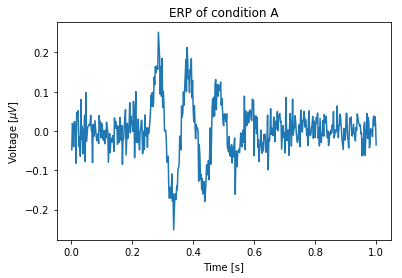

In [97]:
plt.plot(t[0], EEGa.mean(axis=0))  # Plot the ERP of condition A
plt.xlabel('Time [s]')  # Label the axes
plt.ylabel('Voltage [$\mu V$]')
plt.title('ERP of condition A')  # ... provide a title
plt.show()  # ... and show the plot

Notice that in the first line, we use the `mean()` property of the array `EEGa` over the first dimension (recall that Python indexes from 0). The result is the ERP for condition A.

<div class="alert alert-block alert-info">
**Q.** Consider the ERP for condition A plotted above. Update this figure to include a vertical line at the location of the stimulus, and the ERP for condition B. How, if at all, do the ERPs for Conditions A and B differ?
</div>

The ERP of condition A shows the mean voltage across trials at each moment in time. Visual inspection suggests that before stimulus presentation (i.e., times 0 s to 0.25 s) the EEG fluctuates around zero. Then, after stimulus presentation, the ERP increases and decreases substantially above and below zero. Which, if any, of these deviations following stimulation are significant? To address this, we make use of the trial structure of the EEG data to compute confidence bounds for the ERP. We do so in two ways.

### Confidence Intervals for the ERP (Method 1)
To compute the ERP we average the EEG data across many trials. Because of this, we may make use of a powerful theorem in statistics—the *central limit theorem* (CLT)—to include approximate confidence bounds in the ERP figure. Briefly, this theorem states that the mean of a sufficiently large number of independent random variables, each with finite mean and variance, will be approximately normally distributed. Remember that the ERP at each moment in time is the sum of EEG activity across trials (then scaled by a constant, the number of trials). Let’s assume that the trials are independent (i.e., one trial does not depend on any other trial). Let’s also assume that the EEG data at each moment in time have finite mean and variance. With those assumptions, we have satisfied the CLT and may therefore conclude that the ERP at each moment in time is approximately normally distributed.

<div class="alert alert-block alert-info">
**Q.** To use the CLT, we make two assumptions about the EEG data. Are these assumptions reasonable?
<br><br>
**A.** We assume that the EEG data are independent across trials. This assumption may fail if, for example, the activity in one trial influences the activity in the next trial. We also assume that the EEG data are “well-behaved” (i.e., have finite mean and variance). That is a reasonable assumption for physical data we observe from the brain; we expect the EEG data to always remain finite and not diverge to plus or minus infinity.
</div>

This conclusion—that the ERP at each moment in time is approximately normally distributed—is useful because the normal distribution (also known as the Gaussian distribution or bell curve) possesses many convenient properties. First, a normal distribution is relatively simple; it can be completely specified with two parameters: the mean value and the standard deviation. Second, 95% of the values drawn from a normal distribution lie within approximately two standard deviations of the mean.

<img src="imgs/gaussian.PNG" alt="Example Gaussian" title="Canonical normal distribution showing mean (dotted vertical line) and standard deviation (blue). Ninety-five percent of values lie within the interval indicated by the red bar. " width="60%" />

Therefore, to construct a 95% confidence interval for the ERP, we need to determine the mean and standard deviation of the mean across trials at each point in time. To compute the mean in Python is easy:

In [100]:
mn = EEGa.mean(0)  # Compute the mean across trials (the ERP)

<div class="alert alert-block alert-warning">
Note that when we refer to the *mean* here we could instead write *sample mean* because we use the observed data to estimate the theoretical mean that we would see if we kept repeating this experiment. This distinction is not essential to our goals here, but it is important when talking to your statistics-minded colleagues. Throughout the book, we omit the term sample when referring to sample means, variances, covariances, and so forth, unless this distinction is essential to the discussion.
</div>

We again note that the input to the `mean()` property specifies the dimension in which we compute the mean, in this case, across the first dimension of the variable `EEGa` corresponding to the trials. To compute the standard deviation of the mean, we start by computing the standard deviation of the data:

In [102]:
sd = EEGa.std(0)  # Compute the std across trials

But we’re not interested in the standard deviation of the EEG data across trials; instead, we’re interested in the standard deviation of the estimate of the mean. To calculate the standard deviation of the mean, we divide the standard deviation of the data by the square root of the number of trials (i.e., the number of terms used to compute the mean; see the appendix at the end of this chapter). In Python,

In [106]:
import numpy as np  # import the NumPy module 
sdmn = sd / np.sqrt(ntrials)  # Compute the std of the mean

Now, having found the mean and the standard deviation of the mean, we can compute a 95% confidence interval for the ERP. We again exploit the observation, based on the central limit theorem, that the ERP is normally distributed at each instant of time. With these calculations, the following MATLAB code plots the ERP and the 95% confidence interval:

In [116]:
# Import a few functions for convenience
from matplotlib.pyplot import plot, xlabel, ylabel, title, show

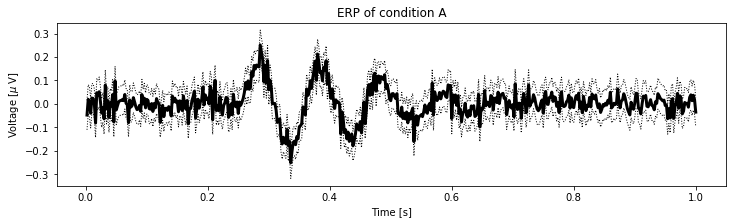

In [174]:
fig = plt.figure(figsize=(12,3))  # Resize the figure
plot(t[0], mn, 'k', lw=3)  # Plot the ERP of condition A
plot(t[0], mn + 2 * sdmn, 'k:', lw=1)  # ... and include the upper CI
plot(t[0], mn - 2 * sdmn, 'k:', lw=1)  # ... and the lower CI
xlabel('Time [s]')  # Label the axes
ylabel('Voltage [$\mu$ V]')
title('ERP of condition A')  # ... provide a useful title
show()  # ... and show the plot

The ERP computed with confidence intervals allows us to ask specific questions about the data. For example, does the ERP ever differ significantly from zero? To asnwer this, we look for intervals of the ERP for which the confidence intervals to no include zero. To aid visual inspection, we add to the ERP plot a horizontal line at 0:

<img src="imgs/ERPaCi.png" alt="ERP of condition A with line at 0" title="The ERP for condition A with 95% confidence intervals. The thick line indicates the ERP (i.e., the mean of the EEG across trials) while the thin dotted lines indicate the 95% confidence intervals.">

<div class="alert alert-block alert-info">
**Q.** Use the following in the code above to add a horizontal line to the plot of the ERP: <br><br>
<div align="center">
`plot(t[0], np.zeros_like(mn), 'b:')`</div>
</div>

<div class="alert alert-block alert-info">
**Q.** What is the role of the NumPy function `zeros_like()` in this code? *Hint*: If you have not encountered this function before, look it up in the Documentation.
</div>

We find three time intervals at which the confidence intervals of the ERP do not include zero: near 0.27 s, near 0.37 s, and near 0.47 s. These results suggest that for an interval of time following the stimulus presentation in condition A, the observed ERP is not a random fluctuation about zero but instead contains consistent structure across trials.

<div class="alert alert-block alert-info">
**Q.** Construct the ERP with confidence intervals for condition B. As for condition A, you should find that before stimulus presentation the ERP fluctuates around zero. What intervals of time, if any, differ significantly from zero?
</div>

### Comparing ERPs <a class="anchor" id="comparing-erps"></a>

In [ ]:
In the